In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [48]:
img = imread('/Users/simon/Projects/Lena.png')
kernel = array([[0,0,0],[0,1,0],[0,0,0]])

In [46]:
%%time
c = 0
img_size = img.shape
kernel_size = kernel.shape
new_img = zeros((img_size[0] + kernel_size[0] ,img_size[1] + kernel_size[1] ,img_size[2]))
for k in range(img_size[2]):
    for i in range(1-kernel_size[0],img_size[0]):
        for j in range(1-kernel_size[1],img_size[1]):
            reg = 0
            for p in range(kernel_size[0]):
                for q in range(kernel_size[1]):
                    if i+p >= 0 and i+p < img_size[0] and j+q >= 0 and j+q < img_size[1] :
                        c = c + 1
                        new_img[i + kernel_size[0] - 1,j + kernel_size[1] - 1,k] = \
                        new_img[i + kernel_size[0] - 1,j + kernel_size[1] - 1,k] + img[i+p,j+q,k] * kernel[p,q] 
                        reg = reg + kernel[p,q]
            if reg :
                new_img[i + kernel_size[0] - 1,j + kernel_size[1] - 1,k] = \
                new_img[i + kernel_size[0] - 1,j + kernel_size[1] - 1,k] / reg
c

CPU times: user 32.9 s, sys: 123 ms, total: 33 s
Wall time: 33.4 s


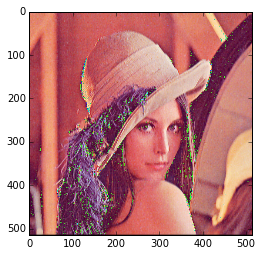

In [50]:
imshow(new_img)

In [44]:
new_img

array([[[ 0.        ,  0.        ,  0.        ],
        [ 0.88627452,  0.53725493,  0.49019608],
        [ 0.88627452,  0.53725493,  0.49019608],
        ..., 
        [ 0.78431374,  0.3882353 ,  0.35294119],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       [[ 0.88627452,  0.53725493,  0.49019608],
        [ 0.88627452,  0.53725493,  0.49019608],
        [ 0.88039216,  0.53725493,  0.50588237],
        ..., 
        [ 0.86666667,  0.50980395,  0.43137255],
        [ 0.78431374,  0.3882353 ,  0.35294119],
        [ 0.        ,  0.        ,  0.        ]],

       [[ 0.88627452,  0.53725493,  0.49019608],
        [ 0.88627452,  0.53725493,  0.49019608],
        [ 0.88235295,  0.53725493,  0.5006536 ],
        ..., 
        [ 0.82549021,  0.44901963,  0.39215687],
        [ 0.78431374,  0.3882353 ,  0.35294119],
        [ 0.        ,  0.        ,  0.        ]],

       ..., 
       [[ 0.32156864,  0.08627451,  0.22352941],
        

###下面是库函数，要快很多

In [53]:
%%time
from scipy import signal
img_size = img.shape
new_img = zeros(img_size)
for i in range(img_size[2]):
    new_img[:,:,i]=signal.convolve2d(img[:,:,i],kernel,mode="same")


CPU times: user 43.4 ms, sys: 2.06 ms, total: 45.4 ms
Wall time: 44.7 ms


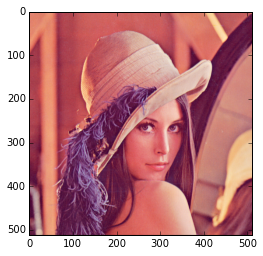

In [52]:
imshow(new_img)

In [3]:
#卷积核正则化
def reg_kern(kernel):
    return kernel / kernel.sum()

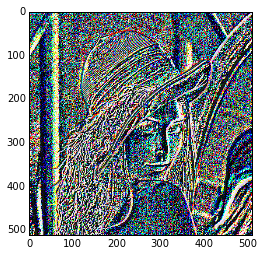

In [7]:
from scipy import signal

kernel = reg_kern(array([[0,-1,0],[-1,1,-1],[0,-1,0]]))
img_size = img.shape
new_img = zeros(img_size)
for i in range(img_size[2]):
    new_img[:,:,i]=signal.convolve2d(img[:,:,i],kernel,mode="same")

imshow(new_img)

###基于FFT的卷积，据说速度更快

In [72]:
def fft_conv(img,kernel):
    img_size = img.shape
    kernel_size = kernel.shape

    n = img_size[0]+kernel_size[0]-1
    m = img_size[1]+kernel_size[1]-1
    N = 2**(int(np.log2(n)))
    M = 2**(int(np.log2(m)))
    A = np.fft.fft2(img, (N,M))
    B = np.fft.fft2(kernel, (N,M))
    return np.fft.ifft2(A*B)[:img_size[0],:img_size[1]]
def rfft_conv(img,kernel):
    img_size = img.shape
    kernel_size = kernel.shape

    n = img_size[0]+kernel_size[0]-1
    m = img_size[1]+kernel_size[1]-1
    N = 2**(int(np.log2(n)))
    M = 2**(int(np.log2(m)))
    A = np.fft.rfft2(img, (N,M))
    B = np.fft.rfft2(kernel, (N,M))
    return np.fft.irfft2(A*B)[:img_size[0],:img_size[1]]

In [66]:
%%time
for i in range(img_size[2]):
    new_img[:,:,i]=fft_conv(img[:,:,i],kernel)
    

CPU times: user 73.8 ms, sys: 24.7 ms, total: 98.6 ms
Wall time: 98.3 ms


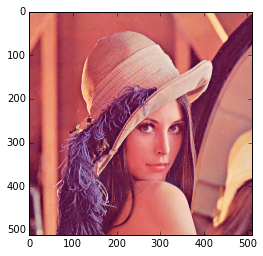

In [63]:
imshow(new_img)

###性能测试

In [76]:
r = random.rand(10000,10000)
%timeit signal.convolve2d(r,kernel,mode="same")
%timeit fft_conv(r,kernel)
%timeit rfft_conv(r,kernel)

1 loops, best of 3: 4.39 s per loop
1 loops, best of 3: 45.1 s per loop
1 loops, best of 3: 12.2 s per loop


###结果并没有太大变化
FFT反而满额了，RFFT会快一点，似乎没有复杂度变化。
而且在数据量大时，系统自带的似乎会更快一点，所以复杂度应该没有差别。
由此可以得到结论，scipy的卷积时基于FFT的，而numpy的似乎不是。